In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser  = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim import matutils
from gensim.models import CoherenceModel

from operator import itemgetter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from absa_functions import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

<ipython-input-3-3309e384d275>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [4]:
train_path = 'val.xml'
corpus_df, categories = create_corpus(train_path)

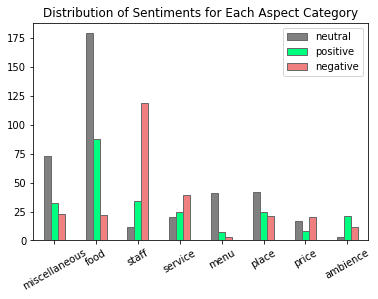

In [5]:
counts = {}
for cat in categories:
    counts.update({cat: dict(corpus_df[f'{cat}'].value_counts())})

count_df = pd.DataFrame(counts).transpose()

count_df.plot(kind = 'bar', color = ['grey', 'springgreen', 'lightcoral'], edgecolor = 'dimgrey')
plt.xticks(rotation = 30);
plt.title('Distribution of Sentiments for Each Aspect Category');

In [6]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
text_data = preprocess_corpus(corpus_df)

In [8]:
dictionary, corpus = create_bagofwords(text_data)

In [9]:
lda_model = gensim.models.ldamodel.LdaModel.load('best_lda_model.gensim')

In [10]:
topic_match_df = apply_lda_to_corpus(lda_model, corpus, corpus_df, categories)
topic_match_df.head()

,miscellaneous,food,staff,service,menu,place,price,ambience,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017863,0.168736,0.017863,0.349116,0.017963,0.017981,0.410479
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015876,0.015884,0.015885,0.015907,0.368302,0.015881,0.552265
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.154020,0.011025,0.104821,0.011000,0.617581,0.090511,0.011042
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.012991,0.414001,0.103955,0.013005,0.430002,0.013011,0.013035
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.017862,0.388430,0.017876,0.274768,0.017872,0.017933,0.265259


Text(0.5, 1.0, 'Correlation Between Latent Topics and Topic Labels')

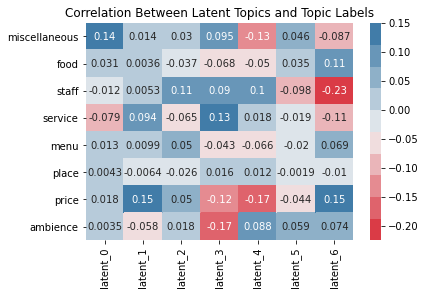

In [11]:
topic_corr = topic_match_df.corr()[[f'latent_{i}' for i in range(0,len(categories) - 1)]][0:len(categories)]

sns.heatmap(topic_corr, annot=True, cmap=sns.diverging_palette(10 ,240, n=10))
plt.title('Correlation Between Latent Topics and Topic Labels')

In [12]:
#numerical mapping for topics in LDA model
topic_map = {0: 'menu', 1: 'service', 2: 'miscellaneous', 3: 'place', 4: 'price', 5: 'food', 6: 'staff'}

In [13]:
lda_df = compile_strong_topics(lda_model, corpus, corpus_df, topic_map)
lda_df.head()

,text,lda_topic
0,"I would wait for a table next time, the food was that good.","{'staff': 0.41066456, 'place': 0.34895578}"
1,"We did complain to the manager, but she just said there are problems in the kitchen and took the drinks off bill.","{'staff': 0.5520927, 'price': 0.3684776}"
2,the service was inattentive (didn't bring us wine til our main course was already served and didn't open the bottle in front of us!!!,"{'price': 0.61758065, 'menu': 0.15401812}"
3,"decent, if greasy, fishsticks, but served on a mound of soggy fries that could feed about 5-6 people!","{'price': 0.43000212, 'service': 0.4140011}"
4,"The Filet Mignon is awesome, along with everything else on the menu.","{'service': 0.3884305, 'place': 0.2747818}"


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
lda_df = sentiment_analysis(lda_df, categories)
lda_df.head()

,text,lda_topic,vader_score,compound_score,sentiment,miscellaneous,food,staff,service,menu,place,price,ambience
0,"I would wait for a table next time, the food was that good.","{'staff': 0.41066456, 'place': 0.34895578}","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}",0.4404,positive,NaN,NaN,positive,NaN,NaN,positive,NaN,None
1,"We did complain to the manager, but she just said there are problems in the kitchen and took the drinks off bill.","{'staff': 0.5520927, 'price': 0.3684776}","{'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.6486}",-0.6486,negative,NaN,NaN,negative,NaN,NaN,NaN,negative,None
2,the service was inattentive (didn't bring us wine til our main course was already served and didn't open the bottle in front of us!!!,"{'price': 0.61758065, 'menu': 0.15401812}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,NaN,NaN,neutral,NaN,neutral,None
3,"decent, if greasy, fishsticks, but served on a mound of soggy fries that could feed about 5-6 people!","{'price': 0.43000212, 'service': 0.4140011}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,NaN,neutral,NaN,NaN,neutral,None
4,"The Filet Mignon is awesome, along with everything else on the menu.","{'service': 0.3884305, 'place': 0.2747818}","{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'compound': 0.6249}",0.6249,positive,NaN,NaN,NaN,positive,NaN,positive,NaN,None


In [16]:
pred_cats_df = create_label_df(corpus_df, categories)
true_cats_df = create_label_df(lda_df, categories)

accuracy = calculate_accuracy(pred_cats_df, true_cats_df)
print(accuracy)

54.85588972431078


In [ ]:
pred_cats_enum_df = add_label_col(pred_cats_df, categories)
true_cats_enum_df = add_label_col(true_cats_df, categories)

precision, recall, f1 = calculate_scores(pred_cats_enum_df, true_cats_enum_df)

print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')